In [2]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re
from nltk.corpus import stopwords
from langdetect import detect
import nltk
from collections import Counter
from transformers import pipeline
import plotly.express as px
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import tensorflow as tf
from google.colab import output
import time
from joblib import Parallel, delayed
import math
import os
import subprocess
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 40.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=f3b9ddeeff728691045570e047aafcf2fac4231f3fa083494dbf5f2b2b06d710
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


# Chargement des données

In [3]:
df1 = pd.read_csv("/content/fictitious_rental_data", sep=';')

In [4]:
df1.head()

,VERBATIM_TRANSLATED_EN_verbatim
0,"The pick-up was quick and efficient, but the r..."
1,"I loved the friendly service, but the car had ..."
2,"The rental price was great, but I was charged ..."
3,"The vehicle was clean and smelled fresh, but t..."
4,"The online booking system was user-friendly, b..."


In [5]:
df1.shape

(200, 1)

In [6]:
df1.isna().sum()

,0
VERBATIM_TRANSLATED_EN_verbatim,0


In [8]:
# df1["VERBATIM_TRANSLATED_EN_verbatim"] = df1["VERBATIM_TRANSLATED_EN_verbatim"].astype(str).fillna("")

## Surveillance du GPU en temps réel

In [9]:
def get_gpu_memory():
    result = subprocess.run(['nvidia-smi', '--query-gpu=memory.used,memory.free', '--format=csv,noheader,nounits'], stdout=subprocess.PIPE)
    memory = result.stdout.decode('utf-8').strip().split('\n')[0].split(', ')
    used_memory = memory[0]
    free_memory = memory[1]
    return used_memory, free_memory

def display_gpu_memory():
    while True:
        used, free = get_gpu_memory()
        print(f"Used: {used}MB, Free: {free}MB")
        time.sleep(20)

# Lancer l'affichage en boucle dans un thread séparé
import threading

gpu_thread = threading.Thread(target=display_gpu_memory)
gpu_thread.daemon = True  # Le thread sera arrêté lorsque le notebook sera arrêté
gpu_thread.start()

Used: 0MB, Free: 15095MB


In [10]:
torch.cuda.is_available()

True

## Modèles

In [11]:
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0)     # device=0
sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english", device=0)   # device=0

concepts = ['staff attitude', 'staff professionalism', 'waiting time',
       'vehicle pick up', 'vehicle verification', 'vehicle return',
       'opening hours', 'parking and station accessibility',
       'information - documents clarity provided',
       'aggressive sales - insistance', 'language', 'comfort',
       'shuttle - off-airport commuting', 'booking', 'booking management',
       'method of payment', 'invoicing', 'damage dispute',
       'refund - commercial gesture', 'customer service - call center',
       'deposit', 'lost property', 'website',
       'account access and management', 'technological issues',
       'mobile app', 'epidemic', 'brand reputation - churn',
       'fraud - personal data', 'general satisfaction - service quality',
       'additional charges', 'pricing - value for money', 'tolls',
       'coverage options - protection', 'deskless',
       'loyalty - partner offers', 'delivery - collection',
       'pre-registration - paperwork', 'roadside assistance',
       'cleanliness', 'vehicles available - same as booked',
       'vehicle performance - equipment and features',
       'vehicle look - feel', 'fuel - battery',
       'vehicle condition and mechanics', 'electric  - hybrid vehicles']

final_keyword_concepts = {
    "staff attitude": [
        "friendly", "rude", "impolite", "kind", "polite", "helpful",
        "attitude", "courteous", "disrespectful", "gracious", "warm",
        "welcoming", "staff was rude", "staff was kind",
        "staff attitude was exceptional", "unpleasant attitude", "empathy"
    ],
    "staff professionalism": [
        "professional", "unprofessional", "knowledgeable", "competent", "expert",
        "skilled", "experienced", "proficient", "amateurish", "trained",
        "staff was highly professional", "staff lacked professionalism",
        "staff was not knowledgeable", "untrained staff", "helpful"
    ],
    "waiting time": [
        "wait", "delay", "time", "long", "short", "duration", "quickly",
        "promptly", "instant", "prolonged", "delayed", "waiting time was too long",
        "quick response", "waiting time was minimal", "delay in service"
    ],
    "vehicle pick up": [
        "pickup", "pick-up", "retrieve", "collect", "get the car", "get the car keys",
        "retrieve car", "get vehicle", "take car", "car pickup was smooth",
        "pickup was delayed", "easy pickup", "pickup process was unclear"
    ],
    "vehicle verification": [
        "check", "inspection", "verify", "verification", "validate", "existing damage",
        "inspection process", "car check", "pre-check", "car verification was thorough",
        "inspection not detailed enough", "verification was fast",
        "statement of damages"
    ],
    "vehicle return": [
        "return", "drop-off", "give back", "late", "delay", "returning car",
        "vehicle drop-off", "handover", "give back vehicle", "car return was quick",
        "late return", "delayed drop-off", "return process was clear", "key box", "return box"
    ],
    "opening hours": [
        "hours", "schedule", "open", "closed", "availability", "open late",
        "not open when expected", "open hours unclear", "store closed", "delayed flight"
    ],
    "parking and station accessibility": [
        "accessible", "access", "difficult to reach", "location", "easy to reach",
        "convenient location", "hard to find", "location issue", "location was hard to find",
        "location was convenient", "easily accessible", "signage"
    ],
    "information - documents clarity provided": [
        "information", "informed", "misinformed", "knowledge", "details",
        "briefing", "instructions", "details provided", "unclear guidance",
        "staff gave correct information", "staff misinformed", "instructions unclear",
        "lack of proper information", "transparency"
    ],
    "aggressive sales - insistance": [
        "persistent", "insistent", "pushy", "overbearing", "forceful sales",
        "sales pressure", "aggressive sales tactics", "too many attempts to sell",
        "insistent upselling", "too much persuasion", "anxiety inducing", "lack of transparency"
    ],
    "language": [
        "language", "communication", "spoken language", "understood", "language barrier",
        "language difficulty", "clear language", "language mismatch", "language issue"
    ],
    "comfort": [
        "comfortable", "uncomfortable", "cozy", "spacious", "seating", "comfortable seats",
        "uncomfortable seats", "tight space", "agency", "station", "water distribution",
        "coffee machine", "shadow"
    ],
    "shuttle - off-airport commuting": [
        "shuttle", "bus", "transport", "commute", "off-airport", "shuttle was on time",
        "off-airport commute was inconvenient", "shuttle service was poor"
    ],
    "booking": [
        "book", "booking", "reserve", "reservation", "simple", "easy", "easy booking process",
        "booking was quick", "booking was difficult"
    ],
    "booking management": [
        "manage booking", "reservation modification", "change booking", "update booking",
        "modify reservation", "change of date", "cancellation", "manage my reservation"
    ],
    "method of payment": [
        "payment", "credit card", "pay", "charge", "transaction", "credit card payment was smooth",
        "payment failed", "charge was incorrect", "transaction went through", "cash payment"
    ],
    "invoicing": [
        "invoice", "billing", "bill", "receipt", "charge", "incorrect invoice",
        "received the wrong bill", "no receipt provided"
    ],
    "damage dispute": [
        "damage", "dispute", "car damage", "damage claim", "disagreement over damage",
        "unresolved damage issue", "damage not covered", "damage was not noted"
    ],
    "refund - commercial gesture": [
        "refund", "reimburse", "compensate", "gesture", "discount", "refund was processed",
        "no refund given", "compensation offered"
    ],
    "customer service - call center": [
        "customer", "support", "helpdesk", "assistance", "service", "helpful team",
        "service desk", "poor assistance", "client care", "customer support was responsive",
        "customer service was unhelpful", "helpful assistance", "customer support", "reachability",
        "answer the phone" ,"try to call"
    ],
    "deposit": [
        "deposit", "security", "down payment", "fee", "charge", "deposit was refunded",
        "no deposit required", "deposit unclear", "deposit release"
    ],
    "lost property": [
        "lost", "property", "forgotten", "item", "belongings", "lost my item",
        "item was found", "belongings misplaced"
    ],
    "website": [
        "error message", "technical error", "website not working", "page not found",
        "website crashed", "unclear website", "website", "online", "portal", "platform",
        "interface", "website is down", "trouble navigating the website",
        "website layout is confusing", "page takes too long to load"
    ],
    "account access and management": [
        "account", "login", "access", "profile", "account management", "password issue",
        "access denied", "unable to access account"
    ],
    "technological issues": [
        "tech", "technical", "issue", "problem", "error", "bug", "technical difficulties",
        "site crashing", "error message displayed"
    ],
    "mobile app": [
        "problem with the app", "app fails", "app not working", "app", "mobile", "application",
        "install", "smartphone", "app keeps crashing", "app runs smoothly", "issue with app login",
        "app freezes constantly", "app interface is bad"
    ],
    "epidemic": [
        "pandemic", "health crisis", "epidemic", "health risk", "covid", "health measures",
        "travel restrictions", "pandemic impact"
    ],
    "brand reputation - churn": [
        "brand reputation", "brand trust", "loyalty", "customer retention", "churn rate",
        "brand image", "poor reputation", "damage to reputation","never again", "don't recommend",
        "recommend"
    ],
    "fraud - personal data": [
        "fraud", "scam", "data", "privacy", "security", "identity theft", "data breach",
        "personal information compromised", "gdpr", "credit card abuse", "legal risk",
        "legal action", "lawyer", "atterney", "prosecution"
    ],
    "general satisfaction - service quality": [
        "very happy", "excellent", "great experience", "good as usual", "awful experience",
        "complaint", "dissatisfied", "unhappy", "disappointed", "satisfaction", "happy",
        "content", "pleased", "overall experience", "pleasure", "frustrated", "worth it",
        "overwhelmingly satisfied", "felt great", "overall positive", "overall negative",
        "extremely disappointed", "excellent service", "pleased with the service",
        "easy process", "efficient", "poor service", "appalling service", "bad service",
        "disappointed with the service", "quality", "service", "superb service", "lack of efficiency",
        "disappointing experience", "quick service", "poor customer handling", "ok"
    ],
    "additional charges": [
        "extra", "charge", "fee", "cost", "unexpected", "hidden fees", "extra charges applied",
        "unexpected cost", "extra fees", "hidden fees", "service fees", "late return fees", "cleaning fees",
        "transparency of charges"
    ],
    "pricing - value for money": [
        "pricing", "price", "cost", "value", "expensive", "cheap", "fair price", "overpriced",
        "reasonable cost", "good value", "fair pricing", "price too high",
        "value for money", "reasonable cost", "worth it", "pricing is expensive", "pricing is too high",
        "worth the price", "too costly", "affordability", "fairness of pricing", "promotion", "rate"
    ],
    "tolls": [
        "toll", "road fee", "charge", "highway cost", "toll costs", "unexpected tolls"
    ],
    "coverage options - protection": [
        "coverage", "insurance", "protection", "policy", "full coverage", "additional coverage",
        "insurance options", "excess protection", "coverage plan"
    ],
    "deskless": [
        "deskless", "no desk", "on-the-go", "automated pickup", "automated key collection",
        "no physical desk"
    ],
    "loyalty - partner offers": [
        "loyalty", "partner offers", "points", "membership", "benefits", "special treatment",
        "loyalty program", "partner deals", "bonus points", "rewards"
    ],
    "delivery - collection": [
        "delivery", "collection", "drop-off", "quick delivery", "delayed delivery",
        "car collection", "delivery process"
    ],
    "pre-registration - paperwork": [
        "pre-registration", "paperwork", "forms", "documents", "required documentation", "register",
        "administration", "pre-registration process", "signature", "online check in"
    ],
    "roadside assistance": [
        "roadside assistance", "help on the road", "emergency", "mechanical issue", "flat tyre",
        "roadside service", "assistance provided","breakdown", "broken down vehicle"
    ],
    "cleanliness": [
        "clean", "dirty", "spotless", "messy", "filthy", "cleanliness can be improved",
        "tidy", "well-maintained", "dirty interior", "unpleasant odor", "car was clean",
        "interior was messy", "cleanliness was fine", "windshield", "dirty mirrors"
    ],
    "vehicles available - same as booked": [
        "same as booked", "vehicle availability", "car as booked", "exact model", "same vehicle",
        "different car", "substitute vehicle", "vehicle category"
    ],
    "vehicle performance - equipment and features": [
        "performance", "engine", "speed", "power", "handling", "smooth ride", "engine noise",
        "efficient", "powerful", "mechanical issue", "good performance", "poor engine",
        "noisy engine", "no navsat", "no gps", "vehicle too big", "vehicle too small"
    ],
    "vehicle look - feel": [
        "appearance", "look", "feel", "design", "car aesthetics", "interior look", "car condition",
        "looks as expected", "modern design", "vehicle was poor", "existing dents", "existing scratches",
        "bodywork"
    ],
    "fuel - battery": [
        "fuel", "battery", "tank", "electric", "battery life", "fuel efficiency", "range",
        "full tank", "battery charge", "fuel economy", "autonomy", "empty", "full"
    ],
    "vehicle condition and mechanics": [
        "maintenance", "mechanics", "engine", "wear and tear", "car was well-maintained",
        "vehicle issue", "mechanical failure", "fluid", "windshield", "tyres", "air pressure",
        "slick tyres", "dashboard light", "warning light", "adblue", "safety", "risk"
    ],
    "electric - hybrid vehicles": [
        "electric", "hybrid", "eco-friendly", "green", "battery", "electric car", "hybrid option",
        "eco-friendly car", "autonomy", "range"
    ]
}

def analyze_segments(segments, threshold=0.95):
    sentiment_map = {}  # Dictionnaire pour stocker les sentiments finaux par concept

    for segment in tqdm(segments, desc="Processing segments"):
        if len(segment.strip()) == 0:
            continue

        # Détection des concepts supplémentaires via les mots-clés
        additional_concepts = detect_additional_concepts(segment)
        dynamic_labels = list(set(list(final_keyword_concepts.keys()) + additional_concepts))

        # Classification de chaque segment
        classification = classifier(segment, candidate_labels=dynamic_labels, multi_label=True)
        relevant_concepts = [label for label, score in zip(classification['labels'], classification['scores']) if score >= threshold]

        # Analyse de sentiment de chaque segment
        sentiment = sentiment_analyzer(segment)[0]
        sentiment_label = "Positive" if sentiment["label"] == "POSITIVE" else "Negative"

        # Ajout des concepts et priorisation des sentiments
        for concept in relevant_concepts:
            if concept in sentiment_map:
                if sentiment_label == "Negative":
                    sentiment_map[concept] = "Negative"  # Priorité au négatif
            else:
                sentiment_map[concept] = sentiment_label

    # Formatage du résultat
    results = [f"{concept} : {sentiment}" for concept, sentiment in sentiment_map.items()]
    return ", ".join(results)  # Retourne les résultats séparés par des virgules

# Découpage du texte en segments
def split_text_into_segments(text):
    segments = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|,|\?|!)\s', text)
    return [segment.lower().strip() for segment in segments if len(segment.strip()) > 0]   # strip : élimine les espaces avant et après le segment

# Fonction pour détecter des concepts supplémentaires via mots-clés
def detect_additional_concepts(segment):
    detected_concepts = []
    segment_tokens = set(segment.split())  # Convertir en set pour une recherche rapide
    for concept, keywords in final_keyword_concepts.items():
        if segment_tokens & set(keywords):  # Intersection rapide avec un set
            detected_concepts.append(concept)
    return detected_concepts

# Traitement par batch
batch_size = 32  # Taille du batch (nombre de verbatims par lots)
results = []  # Liste pour stocker les résultats

# Traitement du DataFrame par batches et sauvegarde après chaque batch
for i in tqdm(range(0, len(df1), batch_size), desc="Classification des thèmes", ncols=100):
    # Préparer le batch de textes
    batch_texts = df1['VERBATIM_TRANSLATED_EN_verbatim'].iloc[i:i + batch_size].tolist()

    batch_results = []
    for text in batch_texts:
        # Découpage du texte en segments et analyse des concepts
        segments = split_text_into_segments(text)
        concepts = analyze_segments(segments)

        batch_results.append(concepts)

    # Ajout des résultats du batch à la liste des résultats
    results.extend(batch_results)

    # Sauvegarde des résultats après chaque batch avec tqdm pour le suivi
    df_temp = df1.iloc[:i + batch_size].copy()  # Données traitées jusqu'ici
    df_temp['VERBATIM_TRANSLATED_EN_concepts2'] = results[:i + batch_size]  # Résultats jusqu'ici
    df_temp.to_csv(f"partial_results_{i + batch_size}.csv", index=False)
    #df_temp.to_csv(partial_results_path, index=False)  # Écraser partiellement
    print(f"Enregistrement des résultats jusqu'à la ligne {i + batch_size}...")

# Sauvegarde des résultats finaux
df1['VERBATIM_TRANSLATED_EN_concepts2'] = results
df1.to_csv("Final_Results_with_Concept&Sentiment.csv", index=False)
print("Enregistrement des résultats finaux.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Used: 2MB, Free: 15092MB


tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0
Processing segments: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]

Processing segments:   0%|          | 0/2 [00:00<?, ?it/s]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset

Processing segments: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]

Processing segments:   0%|          | 0/2 [00:00<?, ?it/s]

Used: 1982MB, Free: 13112MB



Processing segments: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

Processing segments: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Used: 1982MB, Free: 13112MB



Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

Processing segments: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]

Processing segments: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]

Processing segments: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]

Processing segments:  50%|█████     | 1/2 [00:00<00:00,  1.14it/s]

Used: 1982MB, Free: 13112MB



Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

Classification des thèmes:  14%|█████▍                                | 1/7 [01:01<06:08, 61.37s/it]

Enregistrement des résultats jusqu'à la ligne 32...



Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

Processing segments: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]

Used: 1982MB, Free: 13112MB


Processing segments: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

Processing segments: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]

Processing segments: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]

Processing segments:  50%|█████     | 1/2 [00:00<00:00,  1.14it/s]

Used: 1982MB, Free: 13112MB



Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]

Processing segments: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]

Processing segments: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

Processing segments:   0%|          | 0/2 [00:00<?, ?it/s]

Used: 1982MB, Free: 13112MB



Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]

Classification des thèmes:  29%|██████████▊                           | 2/7 [02:01<05:04, 60.93s/it]

Enregistrement des résultats jusqu'à la ligne 64...



Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

Processing segments:  50%|█████     | 1/2 [00:01<00:01,  1.14s/it]

Used: 1982MB, Free: 13112MB



Processing segments: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]

Processing segments: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


Used: 1982MB, Free: 13112MB



Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

Processing segments: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

Processing segments: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Used: 1982MB, Free: 13112MB



Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

Classification des thèmes:  43%|████████████████▎                     | 3/7 [02:57<03:53, 58.31s/it]

Enregistrement des résultats jusqu'à la ligne 96...



Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

Processing segments: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

Processing segments: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

Processing segments:   0%|          | 0/1 [00:00<?, ?it/s]

Used: 1982MB, Free: 13112MB



Processing segments: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

Processing segments: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Used: 1982MB, Free: 13112MB



Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]

Processing segments: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

Classification des thèmes:  57%|█████████████████████▋                | 4/7 [03:44<02:41, 53.91s/it]

Enregistrement des résultats jusqu'à la ligne 128...



Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

Processing segments: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]

Processing segments:  50%|█████     | 1/2 [00:00<00:00,  1.10it/s]

Used: 1982MB, Free: 13112MB



Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

Processing segments: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]

Processing segments: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

Processing segments: 100%|██████████| 2/2 [00:0

Used: 1982MB, Free: 13112MB



Processing segments: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

Processing segments: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]

Processing segments: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]

Classification des thèmes:  71%|███████████████████████████▏          | 5/7 [04:27<01:39, 49.93s/it]

Enregistrement des résultats jusqu'à la ligne 160...



Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

Processing segments:   0%|          | 0/2 [00:00<?, ?it/s]

Used: 1982MB, Free: 13112MB



Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

Processing segments: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]

Processing segments: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

Processing segments: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]

Processing segments: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

Processing segments: 100%|██████████| 1/1 [00:0

Used: 1982MB, Free: 13112MB



Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

Processing segments: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

Classification des thèmes:  86%|████████████████████████████████▌     | 6/7 [05:08<00:46, 46.86s/it]

Enregistrement des résultats jusqu'à la ligne 192...



Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

Processing segments: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


Used: 1982MB, Free: 13112MB



Processing segments: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

Processing segments: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

Processing segments: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

Classification des thèmes: 100%|██████████████████████████████████████| 7/7 [05:20<00:00, 45.81s/it]

Enregistrement des résultats jusqu'à la ligne 224...
Enregistrement des résultats finaux.


In [12]:
df1 = pd.read_csv('/content/Final_Results_with_Concept&Sentiment.csv')

In [13]:
df1.head()

,VERBATIM_TRANSLATED_EN_verbatim,VERBATIM_TRANSLATED_EN_concepts2
0,"The pick-up was quick and efficient, but the r...",general satisfaction - service quality : Posit...
1,"I loved the friendly service, but the car had ...",general satisfaction - service quality : Posit...
2,"The rental price was great, but I was charged ...","pricing - value for money : Positive, general ..."
3,"The vehicle was clean and smelled fresh, but t...","cleanliness : Positive, vehicle look - feel : ..."
4,"The online booking system was user-friendly, b...",general satisfaction - service quality : Posit...


In [14]:
df1['VERBATIM_TRANSLATED_EN_concepts2'].isna().sum()

24

In [15]:
df1.dropna(subset=['VERBATIM_TRANSLATED_EN_concepts2'], inplace=True)

In [16]:
def extract_sentiments(concepts_str):
    concepts = concepts_str.split(", ")
    sentiment_dict = {}
    for concept in concepts:
        label, sentiment = concept.split(" : ")
        sentiment_dict[label] = sentiment
    return sentiment_dict

all_sentiments = []
for row in df1['VERBATIM_TRANSLATED_EN_concepts2']:
    all_sentiments.append(extract_sentiments(row))

In [17]:
flattened_data = []

for sentiment_dict in all_sentiments:
    for concept, sentiment in sentiment_dict.items():
        flattened_data.append({'Concept': concept, 'Sentiment': sentiment})

df_sentiments = pd.DataFrame(flattened_data)

In [18]:
sentiment_counts = df_sentiments.groupby(['Concept', 'Sentiment']).size().unstack(fill_value=0)

In [19]:
sentiment_counts = sentiment_counts.sort_values(by='Negative', ascending=False)

In [20]:
sentiment_counts

Sentiment,Negative,Positive
Concept,,
technological issues,32,0
additional charges,29,5
waiting time,20,1
general satisfaction - service quality,19,73
staff attitude,17,12
method of payment,14,3
coverage options - protection,12,5
vehicle condition and mechanics,10,0
lost property,9,1


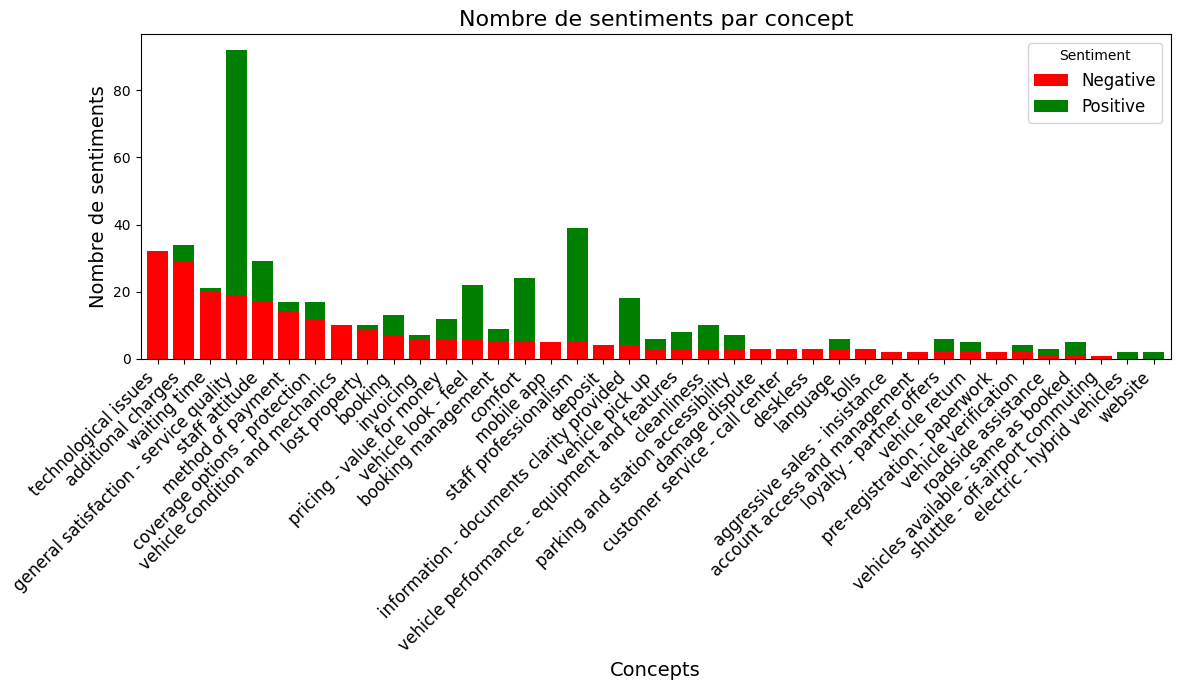

In [21]:
sentiment_counts.plot(kind='bar', stacked=True, figsize=(12, 7), color=['red', 'green'], width=0.8)

plt.title('Nombre de sentiments par concept', fontsize=16)
plt.xlabel('Concepts', fontsize=14)
plt.ylabel('Nombre de sentiments', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.legend(['Negative', 'Positive'], title='Sentiment', fontsize=12)
plt.tight_layout()
plt.show()

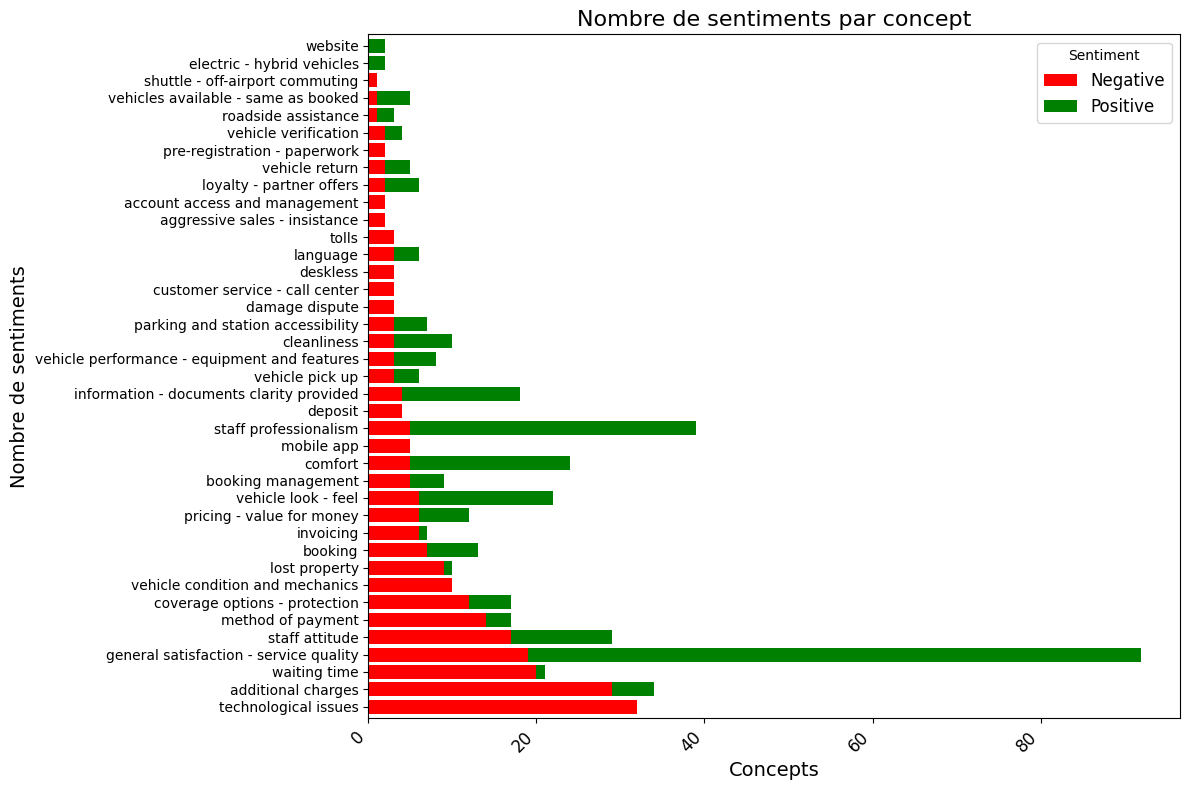

In [22]:
sentiment_counts.plot(kind='barh', stacked=True, figsize=(12, 8), color=['red', 'green'], width=0.8)

plt.title('Nombre de sentiments par concept', fontsize=16)
plt.xlabel('Concepts', fontsize=14)
plt.ylabel('Nombre de sentiments', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.legend(['Negative', 'Positive'], title='Sentiment', fontsize=12)
plt.tight_layout()
plt.show()

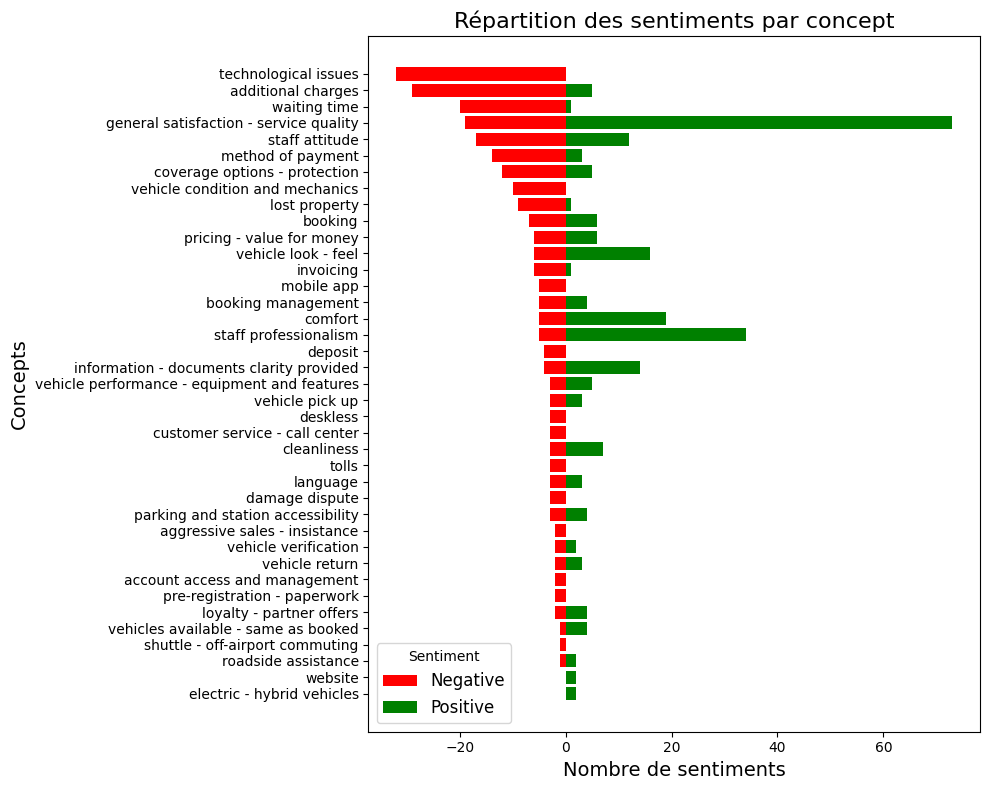

In [23]:
sentiment_counts = df_sentiments.groupby(['Concept', 'Sentiment']).size().unstack(fill_value=0)


sentiment_counts = sentiment_counts.sort_values(by='Negative', ascending=True)


fig, ax = plt.subplots(figsize=(10, 8))


ax.barh(sentiment_counts.index, -sentiment_counts['Negative'], color='red', label='Negative')


ax.barh(sentiment_counts.index, sentiment_counts['Positive'], color='green', label='Positive', left=0)


ax.set_title('Répartition des sentiments par concept', fontsize=16)
ax.set_xlabel('Nombre de sentiments', fontsize=14)
ax.set_ylabel('Concepts', fontsize=14)
ax.legend(title='Sentiment', fontsize=12)

plt.tight_layout()
plt.show()

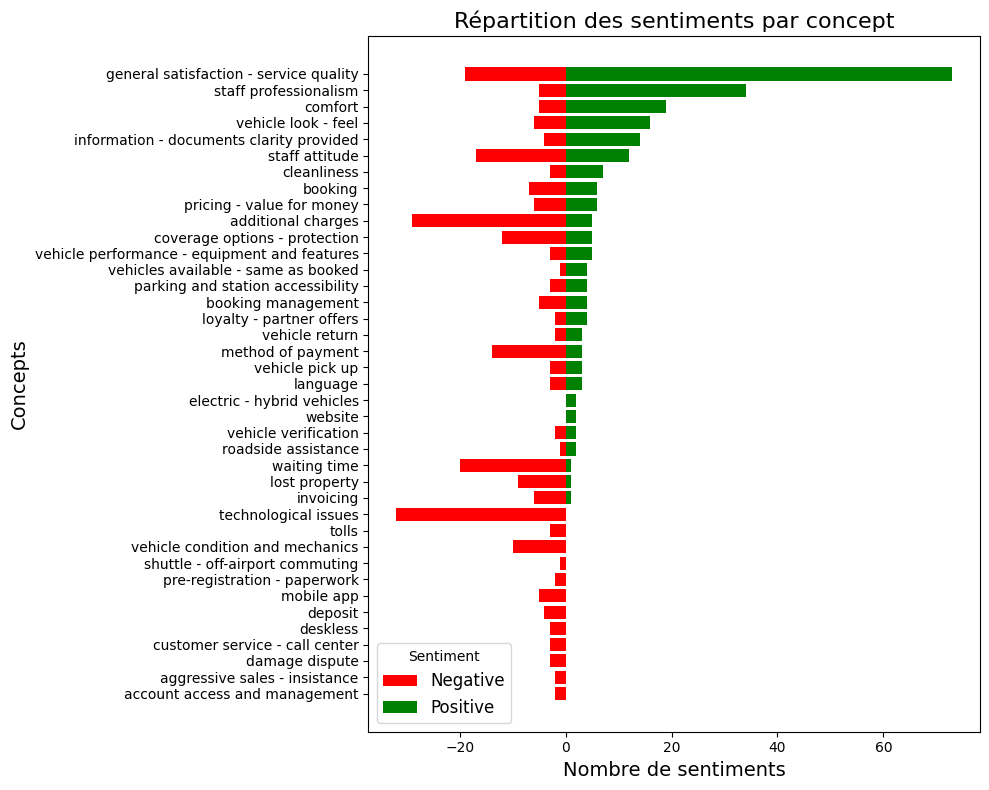

In [24]:
sentiment_counts = df_sentiments.groupby(['Concept', 'Sentiment']).size().unstack(fill_value=0)


sentiment_counts = sentiment_counts.sort_values(by='Positive', ascending=True)


fig, ax = plt.subplots(figsize=(10, 8))


ax.barh(sentiment_counts.index, -sentiment_counts['Negative'], color='red', label='Negative')


ax.barh(sentiment_counts.index, sentiment_counts['Positive'], color='green', label='Positive', left=0)


ax.set_title('Répartition des sentiments par concept', fontsize=16)
ax.set_xlabel('Nombre de sentiments', fontsize=14)
ax.set_ylabel('Concepts', fontsize=14)
ax.legend(title='Sentiment', fontsize=12)


plt.tight_layout()
plt.show()